In [1]:
import cv2
from keras.models import load_model
import numpy as np

In [2]:
video_file = 'drive/MyDrive/VID_20221112_015932.mp4'

In [3]:
import cv2 as cv
import os
import numpy as np
  
  
# The video feed is read in as
# a VideoCapture object
cap = cv.VideoCapture(video_file)

# ret = a boolean return value from
# getting the frame, first_frame = the
# first frame in the entire video sequence
ret, first_frame = cap.read()
height, width, layers = first_frame.shape
size = (height, width)
# Converts frame to grayscale because we
# only need the luminance channel for
# detecting edges - less computationally 
# expensive
prev_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
  
# Creates an image filled with zero
# intensities with the same dimensions 
# as the frame
mask = np.zeros_like(first_frame)
  
# Sets image saturation to maximum
mask[..., 1] = 255
arr_optical_flow = np.zeros(size)
magnitude_flow = np.zeros(size)
count = 0
while(cap.isOpened()):
      
    # ret = a boolean return value from getting
    # the frame, frame = the current frame being
    # projected in the video
    ret, frame = cap.read()
    if ret == False:
      break
    # Opens a new window and displays the input
    # frame
    #cv.imshow("input", frame)
      
    # Converts each frame to grayscale - we previously 
    # only converted the first frame to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
      
    # Calculates dense optical flow by Farneback method
    flow = cv.calcOpticalFlowFarneback(prev_gray, gray, 
                                       None,
                                       0.5, 3, 15, 3, 5, 1.2, 0)
      
    # Computes the magnitude and angle of the 2D vectors
    magnitude, angle = cv.cartToPolar(flow[..., 0], flow[..., 1])
    magnitude_flow += magnitude
    # Sets image hue according to the optical flow 
    # direction
    mask[..., 0] = angle * 180 / np.pi / 2
      
    # Sets image value according to the optical flow
    # magnitude (normalized)
    mask[..., 2] = cv.normalize(magnitude, None, 0, 255, cv.NORM_MINMAX)
      
    # Converts HSV to RGB (BGR) color representation
    rgb = cv.cvtColor(mask, cv.COLOR_HSV2BGR)
    cv.imwrite(os.path.join('out', 'frame' + str(count) + '.jpg'), rgb)
    arr_optical_flow += cv.cvtColor(rgb, cv.COLOR_BGR2GRAY)
    # Opens a new window and displays the output frame
    #cv.imshow("dense optical flow", rgb)
    
    # Updates previous frame
    prev_gray = gray
      
    # Frames are read by intervals of 1 millisecond. The
    # programs breaks out of the while loop when the
    # user presses the 'q' key
    count += 1

 
# The following frees up resources and
# closes all windows
cap.release()
cv.destroyAllWindows()

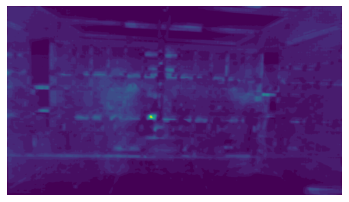

In [17]:
import matplotlib.pyplot as plt
img = plt.imshow((magnitude_flow+arr_optical_flow)//count)
plt.axis('off')
plt.savefig("heatmap.png", bbox_inches='tight')
plt.show()

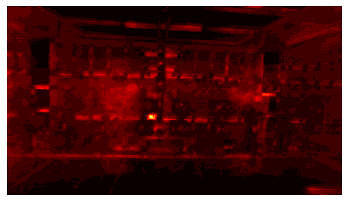

In [52]:
import matplotlib.pyplot as plt
import numpy as np


img = plt.imshow(arr_optical_flow//count, cmap='hot', interpolation='nearest')
img.set_cmap('hot')
plt.axis('off')
plt.savefig("heatmap.png", bbox_inches='tight')
plt.show()

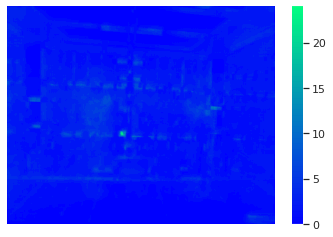

In [54]:
# add alpha (transparency) to a colormap
import matplotlib.cm
from matplotlib.colors import LinearSegmentedColormap 
wd = matplotlib.cm.winter._segmentdata # only has r,g,b  
wd['alpha'] =  ((0.0, 0.0, 0.3), 
               (0.3, 0.3, 1.0),
               (1.0, 1.0, 1.0))

# modified colormap with changing alpha
al_winter = LinearSegmentedColormap('AlphaWinter', wd) 

# get the map image as an array so we can plot it 
import matplotlib.image as mpimg 
map_img = mpimg.imread('first_frame.png') 


import seaborn as sns; sns.set()

hmax = sns.heatmap(arr_optical_flow//count,
            #cmap = al_winter, # this worked but I didn't like it
            cmap = matplotlib.cm.winter,
            alpha = 0.9, # whole heatmap is translucent
            annot = False,
            zorder = 2,
            )

# heatmap uses pcolormesh instead of imshow, so we can't pass through 
# extent as a kwarg, so we can't mmatch the heatmap to the map. Instead, 
# match the map to the heatmap:

hmax.imshow(map_img,
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 1) #put the map under the heatmap

plt.axis('off')
plt.savefig("heatmap1.png", bbox_inches='tight')
from matplotlib.pyplot import show 
show()

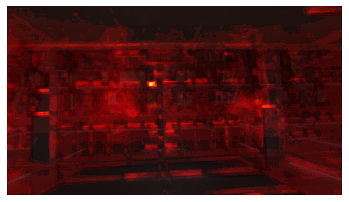

In [55]:
import matplotlib.pyplot as plt
im = plt.imread('first_frame.png')
implot = plt.imshow(im)

plt.imshow(arr_optical_flow//count, cmap='hot', interpolation='nearest', origin='lower', alpha=0.9)

plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')
plt.show()

In [8]:
np.save('arr_optical_flow.ar', arr_optical_flow)

In [60]:
cap = cv.VideoCapture(video_file)

# ret = a boolean return value from
# getting the frame, first_frame = the
# first frame in the entire video sequence
ret, first_frame = cap.read()
count = 0
while ret:
  cv2.imwrite(os.path.join('frames', 'frame' + str(count) + '.png'), first_frame)
  ret, first_frame = cap.read()
  count += 1
cap.release()
cv.destroyAllWindows()

In [61]:
img = first_frame
scale_percent = 50 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

AttributeError: ignored

In [77]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

for each_frame in range(0, 1664, 30):
  img = read_image("frames/frame" + str(each_frame) + ".png")



  # Step 3: Apply inference preprocessing transforms
  batch = [preprocess(img)]

  # Step 4: Use the model and visualize the prediction
  prediction = model(batch)[0]
  labels = [weights.meta["categories"][i] for i in prediction["labels"]]

  box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                            labels=labels,
                            colors="red",
                            width=4, font_size=30)
  im = to_pil_image(box.detach())


/usr/local/lib/python3.7/dist-packages/torchvision/utils.py:237: UserWarning: Argument 'font_size' will be ignored since 'font' is not set.
  warnings.warn("Argument 'font_size' will be ignored since 'font' is not set.")


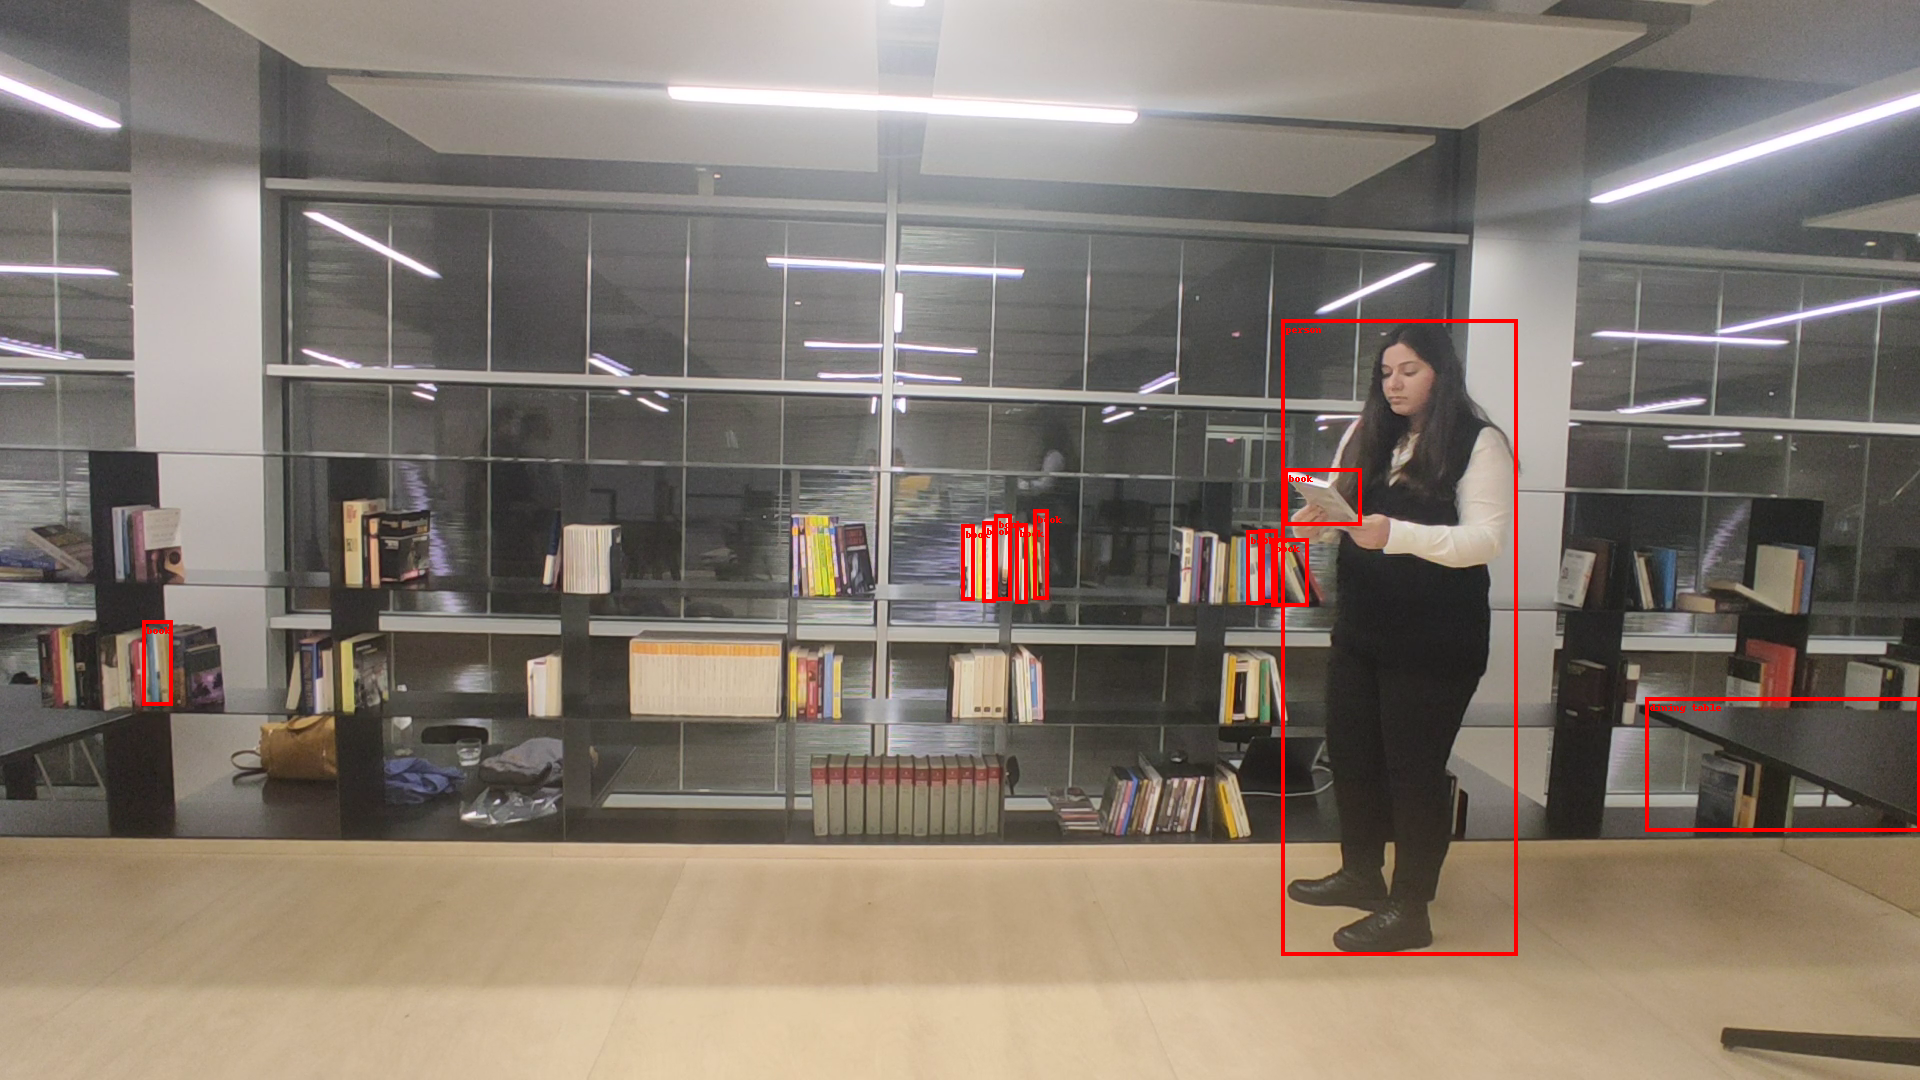

In [78]:
display(im)

In [ ]:
img = cv2.imread("frames/frame259.png")
for box, label in zip(boxes, labels):
  if label == 'person':
    xl, yl, xr, yr = np.round(box.detach().numpy())
    print(xl, yl, xr, yr)
    image = cv2.rectangle(img, (int(xl), int(yr)), (int(xr), int(yl)), (255, 0, 0), -1)

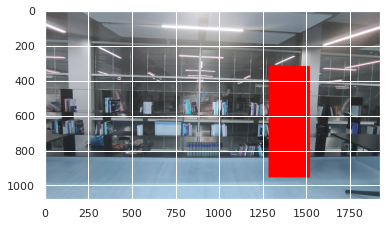

In [108]:
plt.imshow(image)

In [77]:
from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
from torchvision.io import read_image
from pathlib import Path
weights = KeypointRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()
model = keypointrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

for each_frame in range(259, 260):
  name = 'frame' + str(each_frame) + '.png'
  person_int = read_image(str(Path('frames') / name))

  person_float = transforms(person_int)

  outputs = model([person_float])
  kpts = outputs[0]['keypoints']
  scores = outputs[0]['scores']
  detect_threshold = 0.75
  idx = torch.where(scores > detect_threshold)
  keypoints = kpts[idx]
  res = draw_keypoints(person_int, keypoints, colors="red", radius=10)
  #save_image(person_int.float(), os.path.join('new', str(each_frame) + '.png'))

In [78]:
import torch
kpts = outputs[0]['keypoints']
scores = outputs[0]['scores']
detect_threshold = 0.75
idx = torch.where(scores > detect_threshold)
keypoints = kpts[idx]

print(keypoints)

tensor([[[1.3940e+03, 3.8438e+02, 1.0000e+00],
         [1.4069e+03, 3.7143e+02, 1.0000e+00],
         [1.3854e+03, 3.7287e+02, 1.0000e+00],
         [1.4400e+03, 3.7287e+02, 1.0000e+00],
         [1.3767e+03, 3.7575e+02, 1.0000e+00],
         [1.4818e+03, 4.4340e+02, 1.0000e+00],
         [1.3681e+03, 4.3332e+02, 1.0000e+00],
         [1.4832e+03, 5.4271e+02, 1.0000e+00],
         [1.3408e+03, 4.9521e+02, 1.0000e+00],
         [1.3954e+03, 5.3408e+02, 1.0000e+00],
         [1.3292e+03, 5.2112e+02, 1.0000e+00],
         [1.4357e+03, 6.4491e+02, 1.0000e+00],
         [1.3623e+03, 6.3627e+02, 1.0000e+00],
         [1.4156e+03, 7.7157e+02, 1.0000e+00],
         [1.3537e+03, 7.5717e+02, 1.0000e+00],
         [1.4084e+03, 9.1119e+02, 1.0000e+00],
         [1.3580e+03, 8.7232e+02, 1.0000e+00]]], grad_fn=<IndexBackward0>)


In [79]:

import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [80]:
img.shape

(1080, 1920, 3)

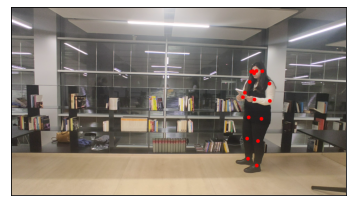

In [81]:
from torchvision.utils import draw_keypoints
import tensorflow as tf
import torchvision

res = draw_keypoints(person_int,
keypoints, colors="red", radius=10)

show(res)

In [82]:
from torchvision.utils import save_image
import torch
import torchvision

save_image(res.float(), 'BIN_ima.png')

In [72]:
from skimage.metrics import structural_similarity
import cv2
import numpy as np


cap = cv.VideoCapture(video_file)

# ret = a boolean return value from
# getting the frame, first_frame = the
# first frame in the entire video sequence
ret, first_frame = cap.read()
height, width, layers = first_frame.shape
size = (height, width)
# Converts frame to grayscale because we
# only need the luminance channel for
# detecting edges - less computationally 
# expensive
first_gray = cv.cvtColor(first_frame, cv.COLOR_BGR2GRAY)
  
# Creates an image filled with zero
# intensities with the same dimensions 
# as the frame
array_diff = np.zeros(first_gray.shape)

count = 0
while(cap.isOpened()):
      
    # ret = a boolean return value from getting
    # the frame, frame = the current frame being
    # projected in the video
    ret, frame = cap.read()
    if ret == False:
      break
    # Opens a new window and displays the input
    # frame
    #cv.imshow("input", frame)
      
    # Converts each frame to grayscale - we previously 
    # only converted the first frame to grayscale
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    diff = gray.copy()
    cv2.absdiff(first_frame, gray, diff)
    array_diff += diff
    count += 1

error: ignored

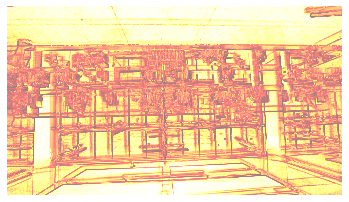

In [71]:
plt.imshow(array_diff//count, cmap='hot', interpolation='nearest', origin='lower', alpha=0.5)

plt.axis('off')
plt.savefig("test.png", bbox_inches='tight')
plt.show()